
Este projeto tem como objetivo detectar áreas queimadas utilizando aprendizado de máquina com dados geoespaciais e espectrais.


#Trazer o repo


In [20]:
# ============================================================
# 1. Clonar repositório (apenas se não existir localmente)
# ============================================================
import os

if not os.path.exists("/content/HackWorCAP-ScarMap"):
    !git clone https://github.com/Templasan/HackWorCAP-ScarMap.git
else:
    print("Repositório já clonado. Pulando download.")

# ============================================================
# 2. Definir caminhos principais do dataset
# ------------------------------------------------------------
# Estrutura esperada:
#   dataset/
#      ├── t1/   (imagens antes)
#      ├── t2/   (imagens depois)
#      └── mask/ (máscaras de cicatrizes)
# ============================================================
base_path = "/content/HackWorCAP-ScarMap/dataset_kaggle/dataset"
t1_path   = os.path.join(base_path, "t1")
t2_path   = os.path.join(base_path, "t2")
mask_path = os.path.join(base_path, "mask")

# ============================================================
# 3. Carregar nomes de arquivos
# ============================================================
t1_files   = sorted(os.listdir(t1_path))
t2_files   = sorted(os.listdir(t2_path))
mask_files = sorted(os.listdir(mask_path))

# ============================================================
# 4. Validar correspondência entre T1, T2 e Máscaras
# ------------------------------------------------------------
# Critério: mesmo nome base (ex.: "recorte_001.tif")
# ============================================================
common = (
    set(f.split(".")[0] for f in t1_files)
  & set(f.split(".")[0] for f in t2_files)
  & set(f.split(".")[0] for f in mask_files)
)

# ============================================================
# 5. Log de integridade do dataset
# ============================================================
print("========== Estatísticas do Dataset ==========")
print(f"Total T1:    {len(t1_files)}")
print(f"Total T2:    {len(t2_files)}")
print(f"Total Mask:  {len(mask_files)}")
print(f"Triplas válidas: {len(common)}")

if common:
    sample = list(common)[0]
    print(f"Exemplo de trio consistente: {sample}.tif")
print("="*45)


Repositório já clonado. Pulando download.
========== Estatísticas do Dataset ==========
Total T1:    945
Total T2:    945
Total Mask:  945
Triplas válidas: 945
Exemplo de trio consistente: recorte_630.tif


In [21]:
# ============================================================
# 6. Instalar dependências
# ------------------------------------------------------------
# Uso de %%capture para evitar poluição do output.
# Pacotes estão organizados por categoria:
#   - Core ML (PyTorch, torchvision, metrics)
#   - Segmentação & Augmentação
#   - Utilitários (visualização, métricas, logging)
#   - Geodados
# ============================================================
%%capture
!pip install -q --upgrade pip

# --- Core ML ---
!pip install -q torch torchvision torchmetrics

# --- Segmentação & Augmentação ---
!pip install -q segmentation-models-pytorch albumentations

# --- Utilitários ---
!pip install -q matplotlib scikit-learn tensorboard tqdm kagglehub

# --- Geodados ---
!pip install -q rasterio


In [22]:
# ============================================================
# Importações necessárias
# ============================================================
import os
import re
import numpy as np
import rasterio

# ============================================================
# Função: Ordenação natural de arquivos
# ============================================================
def natural_sort_key(path):
    """Ordena nomes com números naturalmente: recorte_1 < recorte_2 < recorte_10"""
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', os.path.basename(path))]

# ============================================================
# Função: Criar dataset bitemporal pareado
# ============================================================
def get_bitemporal_dataset(dataset_path):
    """
    Cria dicionário bitemporal {recorte: {"t1": caminho_t1, "t2": caminho_t2, "mask": caminho_mask}}
    """
    t1_dict, t2_dict, mask_dict = {}, {}, {}

    # --- Ler arquivos nos diretórios ---
    for dirname, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            name = os.path.basename(filename)
            if "mask" in dirname.lower():
                mask_dict[name] = full_path
            elif "t1" in dirname.lower():
                t1_dict[name] = full_path
            elif "t2" in dirname.lower():
                t2_dict[name] = full_path

    # --- Ordenar arquivos ---
    t1_files = sorted(t1_dict.keys(), key=natural_sort_key)
    t2_files = sorted(t2_dict.keys(), key=natural_sort_key)
    mask_files = sorted(mask_dict.keys(), key=natural_sort_key)

    # --- Criar dataset bitemporal pareado ---
    dataset_dict = {}
    skipped = 0
    for name in t1_files:
        if name in t2_dict and name in mask_dict:
            dataset_dict[name] = {
                "t1": t1_dict[name],
                "t2": t2_dict[name],
                "mask": mask_dict[name]
            }
        else:
            skipped += 1
            print(f"⚠️ Ignorado (não pareado T1/T2/mask): {name}")

    print(f"✅ Total de recortes pareados: {len(dataset_dict)}")
    if skipped > 0:
        print(f"⚠️ Total de arquivos ignorados: {skipped}")

    return dataset_dict

# ============================================================
# Função: Carregar e processar par de imagens
# ============================================================
def load_and_process_image_pair(t1_path, t2_path, mask_path, indices=["NDVI","NBR"]):
    """
    Carrega imagens t1 e t2 + máscara, calcula índices espectrais e deltas,
    retorna tensor de entrada para o modelo e máscara binária.
    """
    # --- Função interna: leitura e normalização de TIFF ---
    def read_bands_from_tif(file_path):
        """Lê as bandas de um arquivo TIFF e normaliza min-max conjunta"""
        try:
            with rasterio.open(file_path) as src:
                bands = src.read().astype(np.float32)
                if bands.shape[0] < 4:
                    raise ValueError(f"Esperadas pelo menos 4 bandas em {file_path}, mas encontrado {bands.shape[0]}")
                # Normalização min-max conjunta
                bands = (bands - bands.min()) / (bands.max() - bands.min() + 1e-6)
                return bands
        except Exception as e:
            print(f"❌ Erro ao ler {file_path}: {e}")
            raise

    # --- Função interna: cálculo de índices ---
    def calculate_indices(bands, indices):
        """Calcula índices espectrais NDVI e NBR (opcional: outros índices)"""
        red, nir, swir1, swir2 = bands[0], bands[1], bands[2], bands[3]
        idx = {}
        if "NDVI" in indices:
            idx["NDVI"] = (nir - red) / (nir + red + 1e-6)
        if "NBR" in indices:
            idx["NBR"] = (nir - swir1) / (nir + swir1 + 1e-6)
        # Aqui você pode adicionar outros índices como NDMI, BSI, MIRBI...
        return idx

    # --- 1. Ler bandas ---
    pre_bands  = read_bands_from_tif(t1_path)
    post_bands = read_bands_from_tif(t2_path)

    # --- 2. Calcular índices ---
    pre_idx  = calculate_indices(pre_bands, indices)
    post_idx = calculate_indices(post_bands, indices)

    # --- 3. Calcular deltas ---
    delta_idx = {f"delta_{k}": pre_idx[k] - post_idx[k] for k in pre_idx.keys()}

    # --- 4. Empilhar todas as bandas e índices em um tensor ---
    input_stack = np.concatenate([
        pre_bands, post_bands,
        *[pre_idx[k][None] for k in pre_idx.keys()],
        *[post_idx[k][None] for k in post_idx.keys()],
        *[delta_idx[k][None] for k in delta_idx.keys()]
    ], axis=0)

    # --- 5. Ler máscara ---
    with rasterio.open(mask_path) as mask_src:
        mask = mask_src.read(1)
        if mask.shape != input_stack.shape[1:]:
            raise ValueError(f"Tamanho da máscara {mask.shape} difere do tensor de entrada {input_stack.shape[1:]}")
        mask = (mask > 0).astype(np.float32)

    # --- 6. Log resumido ---
    print(f"Tensor entrada: {input_stack.shape}, Min={input_stack.min():.3f}, Max={input_stack.max():.3f}")
    print(f"Máscara: {mask.shape}, Únicos={np.unique(mask)}")

    return input_stack, mask

# ============================================================
# Exemplo de uso das funções
# ============================================================
dataset_path = "/content/HackWorCAP-ScarMap/dataset_kaggle"
dataset_dict = get_bitemporal_dataset(dataset_path)

first_key = list(dataset_dict.keys())[0]
first_t1_path = dataset_dict[first_key]['t1']
first_t2_path = dataset_dict[first_key]['t2']
first_mask_path = dataset_dict[first_key]['mask']

processed_input, processed_mask = load_and_process_image_pair(first_t1_path, first_t2_path, first_mask_path)

print(f"\nShape do tensor de entrada final: {processed_input.shape}")
print(f"Shape da máscara final: {processed_mask.shape}")


✅ Total de recortes pareados: 945
Tensor entrada: (14, 128, 128), Min=-0.319, Max=1.000
Máscara: (128, 128), Únicos=[0.]

Shape do tensor de entrada final: (14, 128, 128)
Shape da máscara final: (128, 128)


In [23]:
# ============================================================
# Exibir exemplos de recortes bitemporais
# ============================================================
print("===== Exemplos de recortes bitemporais =====\n")

# Pegar os primeiros 5 recortes
for i, (name, paths) in enumerate(list(dataset_dict.items())[:5], start=1):
    print(f"--- Exemplo {i}: {name} ---")

    # Checagem de existência dos arquivos
    t1_status = paths['t1'] if os.path.exists(paths['t1']) else "⚠️ T1 não encontrado!"
    t2_status = paths['t2'] if os.path.exists(paths['t2']) else "⚠️ T2 não encontrado!"
    mask_status = paths['mask'] if os.path.exists(paths['mask']) else "⚠️ Máscara não encontrada!"

    print(f"  T1 (todas as bandas): {t1_status}")
    print(f"  T2 (todas as bandas): {t2_status}")
    print(f"  Máscara: {mask_status}\n")

print("="*45)


===== Exemplos de recortes bitemporais =====

--- Exemplo 1: recorte_1.tif ---
  T1 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_1.tif
  T2 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_1.tif
  Máscara: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_1.tif

--- Exemplo 2: recorte_2.tif ---
  T1 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_2.tif
  T2 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_2.tif
  Máscara: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_2.tif

--- Exemplo 3: recorte_3.tif ---
  T1 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_3.tif
  T2 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_3.tif
  Máscara: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_3.tif

--- Exemplo 4: recorte_4.tif ---
  T1 (todas as bandas): 


🔹 Recorte Bitemporal: recorte_3.tif
--------------------------------------------------
📍 T1 (Antes): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_3.tif
📍 T2 (Depois): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_3.tif
📍 Máscara: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_3.tif



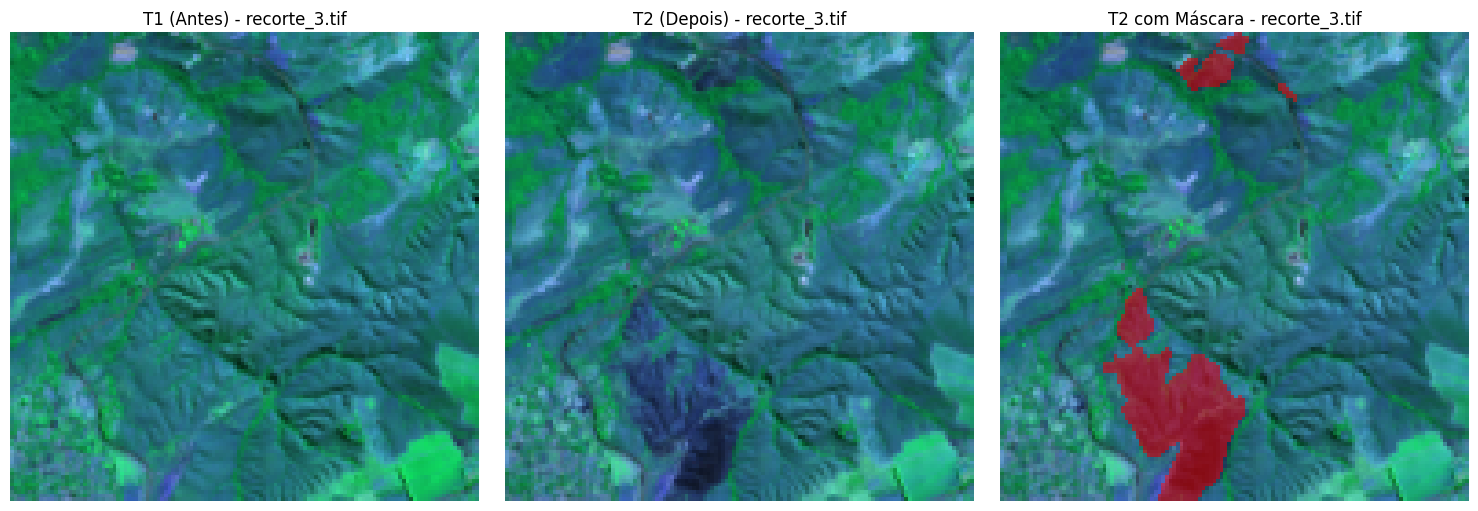

In [24]:
# ============================================================
# Função: Visualizar recorte bitemporal (T1, T2 e máscara)
# ============================================================
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# --- Sub-bloco: Função auxiliar de normalização ---
def normalize_band(band):
    """Normaliza banda ou imagem para [0,1]"""
    band = band.astype(np.float32)
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

# --- Sub-bloco: Função principal ---
def show_sample_bitemporal(dataset_dict, recorte_name, bands=[0,1,2]):
    """
    Mostra T1 e T2 (RGB ou bandas selecionadas) e a máscara para o recorte escolhido.

    Args:
        dataset_dict: dicionário bitemporal {recorte: {"t1", "t2", "mask"}}
        recorte_name: nome do recorte a ser exibido
        bands: lista de índices de bandas para visualização (padrão RGB [0,1,2])
    """
    if recorte_name not in dataset_dict:
        print(f"❌ Recorte '{recorte_name}' não encontrado no dataset.")
        return

    paths = dataset_dict[recorte_name]
    t1_path, t2_path, mask_path = paths['t1'], paths['t2'], paths['mask']

    print("\n" + "="*50)
    print(f"🔹 Recorte Bitemporal: {recorte_name}")
    print("-"*50)
    print(f"📍 T1 (Antes): {t1_path}")
    print(f"📍 T2 (Depois): {t2_path}")
    print(f"📍 Máscara: {mask_path}")
    print("="*50 + "\n")


    # ============================================================
    # Leitura e normalização
    # ============================================================
    try:
        def read_rgb(file_path, bands):
            with rasterio.open(file_path) as src:
                img_bands = src.read()
                # Verifica se há bandas suficientes
                if max(bands) >= img_bands.shape[0]:
                    raise ValueError(f"Arquivo {file_path} não possui banda {max(bands)}")
                img_rgb = np.stack([img_bands[b] for b in bands], axis=-1)
                return normalize_band(img_rgb)

        t1_rgb_norm = read_rgb(t1_path, bands)
        t2_rgb_norm = read_rgb(t2_path, bands)

        with rasterio.open(mask_path) as src_mask:
            mask = src_mask.read(1)
            mask_bin = (mask > 0).astype(np.float32)

        # Checagem de shape
        if t1_rgb_norm.shape[:2] != t2_rgb_norm.shape[:2] or t1_rgb_norm.shape[:2] != mask_bin.shape:
            print("⚠️ Atenção: T1, T2 e máscara têm dimensões diferentes!")
    except Exception as e:
        print(f"❌ Erro ao carregar os arquivos: {e}")
        return

    # ============================================================
    # Visualização
    # ============================================================
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # T1
    axes[0].imshow(t1_rgb_norm)
    axes[0].set_title(f"T1 (Antes) - {recorte_name}")
    axes[0].axis("off")

    # T2
    axes[1].imshow(t2_rgb_norm)
    axes[1].set_title(f"T2 (Depois) - {recorte_name}")
    axes[1].axis("off")

    # Máscara sobre T2
    ax_mask = axes[2]
    ax_mask.imshow(t2_rgb_norm)
    mask_rgba = np.zeros((mask_bin.shape[0], mask_bin.shape[1], 4), dtype=np.float32)
    mask_rgba[..., 0] = 1  # Canal vermelho
    mask_rgba[..., 3] = mask_bin * 0.5  # Transparência
    ax_mask.imshow(mask_rgba)
    ax_mask.set_title(f"T2 com Máscara - {recorte_name}")
    ax_mask.axis("off")

    plt.tight_layout()
    plt.show()

# ============================================================
# Exemplo de uso
# ============================================================
first_key = list(dataset_dict.keys())[2]
show_sample_bitemporal(dataset_dict, first_key)


In [25]:
# ============================================================
# Dataset personalizado para cicatrizes de queimadas
# ============================================================
import torch
from torch.utils.data import Dataset
import numpy as np
import rasterio

# ============================================================
# Função auxiliar: normalização
# ============================================================
def normalize_band(band, method="per_band"):
    """
    Normaliza banda ou imagem para [0,1].

    Args:
        band: np.array da banda ou imagem
        method: "per_band" (default) ou "global"
    """
    band = band.astype(np.float32)
    if method == "per_band":
        normed = (band - band.min(axis=(1,2), keepdims=True)) / (
                 band.max(axis=(1,2), keepdims=True) - band.min(axis=(1,2), keepdims=True) + 1e-6)
    else:  # global
        normed = (band - band.min()) / (band.max() - band.min() + 1e-6)
    return normed

# ============================================================
# Função auxiliar: processar par bitemporal
# ============================================================
def load_and_process_image_pair(t1_path, t2_path, mask_path, indices="NDVI_NBR"):
    """
    Lê imagens T1/T2, calcula índices (NDVI, NBR) e empilha 12 bandas + deltas.

    Args:
        t1_path, t2_path, mask_path: caminhos dos arquivos
        indices: lista de índices ou string "NDVI_NBR" para calcular
    """
    def read_bands(file_path):
        with rasterio.open(file_path) as src:
            if src.count < 4:
                raise ValueError(f"Arquivo {file_path} não possui 4 bandas!")
            bands = src.read().astype(np.float32)
        return bands

    def calc_indices(nir, red, swir):
        ndvi = (nir - red) / (nir + red + 1e-6)
        nbr = (nir - swir) / (nir + swir + 1e-6)
        return ndvi, nbr

    t1_bands = read_bands(t1_path)
    t2_bands = read_bands(t2_path)

    pre_red, pre_nir, pre_swir1, pre_swir2 = t1_bands
    post_red, post_nir, post_swir1, post_swir2 = t2_bands

    pre_ndvi, pre_nbr = calc_indices(pre_nir, pre_red, pre_swir1)
    post_ndvi, post_nbr = calc_indices(post_nir, post_red, post_swir1)

    delta_ndvi = pre_ndvi - post_ndvi
    delta_nbr = pre_nbr - post_nbr

    input_stack = np.stack([
        pre_red, pre_nir, pre_swir1, pre_swir2,
        post_red, post_nir, post_swir1, post_swir2,
        pre_ndvi, post_ndvi, delta_ndvi, delta_nbr
    ], axis=0)

    # Normalização
    input_stack = normalize_band(input_stack, method="per_band")

    # Máscara
    with rasterio.open(mask_path) as src_mask:
        mask = src_mask.read(1)
        mask = (mask > 0).astype(np.float32)

    # Checagem de dimensões
    if input_stack.shape[1:] != mask.shape:
        raise ValueError(f"Dimensões incompatíveis: {input_stack.shape} vs {mask.shape}")

    return input_stack, mask

# ============================================================
# Classe Dataset PyTorch
# ============================================================
class BurnScarDataset(Dataset):
    # --------------------------------------------------------
    # Inicialização
    # --------------------------------------------------------
    def __init__(self, dataset_dict, transform=None, cache=False):
        self.dataset_dict = dataset_dict
        self.keys = list(dataset_dict.keys())
        self.transform = transform
        self.cache_enabled = cache
        self._cache = {}

    # --------------------------------------------------------
    # Tamanho
    # --------------------------------------------------------
    def __len__(self):
        return len(self.keys)

    # --------------------------------------------------------
    # Obter item
    # --------------------------------------------------------
    def __getitem__(self, idx):
        key = self.keys[idx]

        # --- Lazy loading com cache ---
        if self.cache_enabled and key in self._cache:
            image, mask = self._cache[key]
        else:
            paths = self.dataset_dict[key]
            image, mask = load_and_process_image_pair(paths['t1'], paths['t2'], paths['mask'])
            if self.cache_enabled:
                self._cache[key] = (image, mask)

        # --- Transformações ---
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # --- Converte para tensor ---
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        # --- Log de estatísticas (opcional) ---
        if idx < 1:  # só para o primeiro item
            print(f"[DEBUG] {key} -> Image shape: {image.shape}, min={image.min():.3f}, max={image.max():.3f}")

        return image, mask

In [50]:
# ============================================================
# Inspeção do dataset BurnScarDataset
# ============================================================
dataset = BurnScarDataset(dataset_dict)  # ❗ importante: criar a instância do Dataset
N = 3  # número de itens para inspecionar

for i in range(N):
    image, mask = dataset[i]
    print(f"\n📌 Item {i}:")
    print(f"  Image shape: {image.shape}")
    print(f"  Mask shape: {mask.shape}")

    # Estatísticas por canal
    for c in range(image.shape[0]):
        band = image[c].numpy()
        print(f"    Banda {c+1}: min={band.min():.3f}, max={band.max():.3f}, mean={band.mean():.3f}, std={band.std():.3f}")

    # Estatísticas da máscara
    mask_np = mask.numpy()
    print(f"  Mask stats: min={mask_np.min()}, max={mask_np.max()}, mean={mask_np.mean():.3f}, std={mask_np.std():.3f}")



📌 Item 0:
  Image shape: torch.Size([12, 128, 128])
  Mask shape: torch.Size([1, 128, 128])
    Banda 1: min=0.000, max=1.000, mean=0.360, std=0.254
    Banda 2: min=0.000, max=1.000, mean=0.456, std=0.229
    Banda 3: min=0.000, max=1.000, mean=0.429, std=0.260
    Banda 4: min=0.000, max=1.000, mean=0.386, std=0.249
    Banda 5: min=0.000, max=1.000, mean=0.395, std=0.271
    Banda 6: min=0.000, max=1.000, mean=0.448, std=0.222
    Banda 7: min=0.000, max=1.000, mean=0.445, std=0.276
    Banda 8: min=0.000, max=1.000, mean=0.416, std=0.265
    Banda 9: min=0.000, max=1.000, mean=0.566, std=0.236
    Banda 10: min=0.000, max=1.000, mean=0.511, std=0.219
    Banda 11: min=0.000, max=1.000, mean=0.428, std=0.225
    Banda 12: min=0.000, max=1.000, mean=0.425, std=0.232
  Mask stats: min=0.0, max=0.0, mean=0.000, std=0.000

📌 Item 1:
  Image shape: torch.Size([12, 128, 128])
  Mask shape: torch.Size([1, 128, 128])
    Banda 1: min=0.000, max=1.000, mean=0.399, std=0.251
    Banda 2: min

In [26]:
# ============================================================
# Configuração do Modelo U-Net com SMP
# ============================================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

# ============================================================
# --- 1. Dispositivo ---
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔹 Usando o dispositivo: {DEVICE}\n")

# ============================================================
# --- 2. Configurações do Modelo ---
# ============================================================
# Parâmetros flexíveis
IN_CHANNELS = 12        # Número de bandas de entrada
NUM_CLASSES = 1         # Saída binária (1) ou multi-classe (>1)
ENCODER_NAME = "resnet34"  # Nome do encoder SMP
ENCODER_WEIGHTS = "imagenet" # Pesos pré-treinados

# Instancia o modelo
model = smp.Unet(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=IN_CHANNELS,
    classes=NUM_CLASSES,
    activation="sigmoid" if NUM_CLASSES == 1 else "softmax",
).to(DEVICE)

# Checagem rápida
assert model.encoder.conv1.in_channels == IN_CHANNELS, "❌ Número de canais de entrada incorreto!"

# ============================================================
# --- 3. Função de Perda ---
# ============================================================
# Dice Loss padrão para classes desbalanceadas
loss_fn = smp.losses.DiceLoss(mode='binary' if NUM_CLASSES == 1 else 'multiclass', smooth=1.0)

# ============================================================
# --- 4. Otimizador ---
# ============================================================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# --- 5. Prints de Confirmação ---
# ============================================================
print("✅ Modelo, Função de Perda e Otimizador configurados com sucesso!\n")
print("---")
print(f"🔹 Encoder: {ENCODER_NAME}")
print(f"🔹 Canais de Entrada: {IN_CHANNELS}")
print(f"🔹 Número de Classes: {NUM_CLASSES}")
print(f"🔹 Função de Perda: {loss_fn}")
print(f"🔹 Otimizador: {optimizer.__class__.__name__}")
print(f"🔹 Dispositivo: {DEVICE}")

🔹 Usando o dispositivo: cpu



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ Modelo, Função de Perda e Otimizador configurados com sucesso!

---
🔹 Encoder: resnet34
🔹 Canais de Entrada: 12
🔹 Número de Classes: 1
🔹 Função de Perda: DiceLoss()
🔹 Otimizador: Adam
🔹 Dispositivo: cpu


In [45]:
# ============================================================
# BurnScarDataset 12 canais com padding centralizado + Albumentations
# ============================================================
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ============================================================
# Funções auxiliares
# ============================================================
def natural_sort_key(path):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', os.path.basename(path))]

def get_bitemporal_dataset(dataset_path):
    t1_dict, t2_dict, mask_dict = {}, {}, {}
    for dirname, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            if "mask" in dirname.lower():
                mask_dict[filename] = full_path
            elif "t1" in dirname.lower():
                t1_dict[filename] = full_path
            elif "t2" in dirname.lower():
                t2_dict[filename] = full_path

    dataset_dict = {}
    skipped = 0
    for name in t1_dict:
        if name in t2_dict and name in mask_dict:
            dataset_dict[name] = {
                "t1": t1_dict[name],
                "t2": t2_dict[name],
                "mask": mask_dict[name]
            }
        else:
            skipped += 1
            print(f"⚠️ Ignorado: {name}")

    print(f"✅ Total de recortes pareados: {len(dataset_dict)}")
    if skipped > 0:
        print(f"⚠️ Total ignorados: {skipped}")

    return dataset_dict

def robust_normalize(band, lower_percentile=2, upper_percentile=98):
    low, high = np.percentile(band, [lower_percentile, upper_percentile])
    band = np.clip(band, low, high)
    band = (band - low) / (high - low + 1e-6)
    return band.astype(np.float32)

def pad_center(array, target_shape):
    c, h, w = array.shape
    th, tw = target_shape
    padded = np.zeros((c, th, tw), dtype=array.dtype)
    y_offset = (th - h) // 2
    x_offset = (tw - w) // 2
    padded[:, y_offset:y_offset+h, x_offset:x_offset+w] = array
    return padded

def pad_mask_center(mask, target_shape):
    h, w = mask.shape
    th, tw = target_shape
    padded = np.zeros((th, tw), dtype=mask.dtype)
    y_offset = (th - h) // 2
    x_offset = (tw - w) // 2
    padded[y_offset:y_offset+h, x_offset:x_offset+w] = mask
    return padded

# ============================================================
# Carregamento e processamento de imagens
# ============================================================
def load_and_process_image_pair(t1_path, t2_path, mask_path, target_shape=None):
    def read_bands(file_path):
        with rasterio.open(file_path) as src:
            bands = src.read().astype(np.float32)
            if src.count < 4:
                raise ValueError(f"{file_path} tem menos de 4 bandas")
            return [robust_normalize(b) for b in bands[:4]]  # RED, NIR, SWIR1, SWIR2

    def calculate_indices(nir, red, swir1):
        ndvi = (nir - red) / (nir + red + 1e-6)
        nbr = (nir - swir1) / (nir + swir1 + 1e-6)
        return robust_normalize(ndvi), robust_normalize(nbr)

    # Lê bandas
    pre_red, pre_nir, pre_swir1, pre_swir2 = read_bands(t1_path)
    post_red, post_nir, post_swir1, post_swir2 = read_bands(t2_path)

    # Calcula índices
    pre_ndvi, pre_nbr = calculate_indices(pre_nir, pre_red, pre_swir1)
    post_ndvi, post_nbr = calculate_indices(post_nir, post_red, post_swir1)
    delta_ndvi = robust_normalize(pre_ndvi - post_ndvi)
    delta_nbr = robust_normalize(pre_nbr - post_nbr)

    channels = [
        pre_red, pre_nir, pre_swir1, pre_swir2,
        post_red, post_nir, post_swir1, post_swir2,
        pre_ndvi, pre_nbr, delta_ndvi, delta_nbr
    ]

    # Ajusta shapes se necessário
    shapes = [ch.shape for ch in channels]
    if len(set(shapes)) != 1:
        min_h = min([s[0] for s in shapes])
        min_w = min([s[1] for s in shapes])
        channels = [ch[:min_h, :min_w] for ch in channels]

    input_stack = np.stack(channels, axis=0)

    # Lê máscara
    with rasterio.open(mask_path) as src_mask:
        mask = (src_mask.read(1) > 0).astype(np.float32)

    # Padding centralizado
    if target_shape is not None:
        input_stack = pad_center(input_stack, target_shape)
        mask = pad_mask_center(mask, target_shape)

    return input_stack, mask

# ============================================================
# Dataset PyTorch com Albumentations
# ============================================================
class BurnScarDataset(Dataset):
    def __init__(self, dataset_dict, transform=None, target_shape=None):
        self.dataset_dict = dataset_dict
        self.keys = list(dataset_dict.keys())
        self.transform = transform
        self.target_shape = target_shape

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        paths = self.dataset_dict[key]
        image, mask = load_and_process_image_pair(
            paths['t1'], paths['t2'], paths['mask'], target_shape=self.target_shape
        )

        # Albumentations espera HWC, então mudamos temporariamente para (H,W,C)
        image = np.transpose(image, (1,2,0))
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Retorna C,H,W
        image = torch.from_numpy(np.transpose(image, (2,0,1))).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

# ============================================================
# Definindo transformações seguras para 12 canais
# ============================================================
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ], additional_targets={'mask': 'mask'})
    else:
        return A.Compose([], additional_targets={'mask': 'mask'})

# ============================================================
# Criação DataLoaders
# ============================================================
def create_dataloaders(dataset_path, batch_size=4, test_size=0.2, random_seed=42, target_shape=None):
    dataset_dict = get_bitemporal_dataset(dataset_path)
    keys = list(dataset_dict.keys())
    train_keys, val_keys = train_test_split(keys, test_size=test_size, random_state=random_seed)

    train_dataset = BurnScarDataset(
        {k: dataset_dict[k] for k in train_keys},
        transform=get_transforms(train=True),
        target_shape=target_shape
    )
    val_dataset = BurnScarDataset(
        {k: dataset_dict[k] for k in val_keys},
        transform=get_transforms(train=False),
        target_shape=target_shape
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f"✅ DataLoaders criados com sucesso!")
    print(f"  Batches de treino: {len(train_loader)}, tamanho do batch: {batch_size}")
    print(f"  Batches de validação: {len(val_loader)}")
    return train_loader, val_loader

# ============================================================
# Exemplo de uso
# ============================================================
DATASET_PATH = "/content/HackWorCAP-ScarMap/dataset_kaggle"
TARGET_SHAPE = (256, 256)

train_loader, val_loader = create_dataloaders(DATASET_PATH, batch_size=4, target_shape=TARGET_SHAPE)

images, masks = next(iter(train_loader))
print(f"Shape do batch de imagens: {images.shape}")  # (B, 12, H, W)
print(f"Shape do batch de máscaras: {masks.shape}")  # (B, 1, H, W)


✅ Total de recortes pareados: 945
✅ DataLoaders criados com sucesso!
  Batches de treino: 189, tamanho do batch: 4
  Batches de validação: 48
Shape do batch de imagens: torch.Size([4, 12, 256, 256])
Shape do batch de máscaras: torch.Size([4, 1, 256, 256])


In [46]:
# ============================================================
# Funções de métricas otimizadas (float)
# ============================================================
def compute_iou_faster(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    targets = (targets > 0.5).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def compute_f1_faster(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    targets = (targets > 0.5).float()
    tp = (preds * targets).sum(dim=(1, 2, 3))
    fp = (preds * (1 - targets)).sum(dim=(1, 2, 3))
    fn = ((1 - preds) * targets).sum(dim=(1, 2, 3))
    f1 = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return f1.mean().item()

# ============================================================
# Loop de treino e validação
# ============================================================
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS + 1):
    # ---------- Treino ----------
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        # ⚠️ Garantir 12 canais
        if images.shape[1] != 12:
            images = images[:, :12, :, :]
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # ---------- Validação ----------
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_f1 = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            if images.shape[1] != 12:
                images = images[:, :12, :, :]
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item() * images.size(0)
            val_iou += compute_iou_faster(outputs, masks) * images.size(0)
            val_f1 += compute_f1_faster(outputs, masks) * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)
    val_f1 /= len(val_loader.dataset)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Treino Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # ---------- Early stopping simples ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Salvar checkpoint
        torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping após {epoch} epochs sem melhora.")
            break

Epoch 1/50 | Treino Loss: 0.9665 | Val Loss: 0.9893 | IoU: 0.0045 | F1: 0.0087
Epoch 2/50 | Treino Loss: 0.9868 | Val Loss: 0.9889 | IoU: 0.0045 | F1: 0.0087


KeyboardInterrupt: 